In [1]:
# Python:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
# PyTorch
import torch
import torch.nn as nn
from torch.optim import Adam
from torchsummary import summary
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
# RNG, Type, Device:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using {device}")

using cuda


In [2]:
def get_schedules(beta_1, beta_t, timesteps):
    """
    Linear scheduler.
    Useful to pre-compute all the parameters (even fractions, square roots, etc).
    """
    beta_t = (beta_t - beta_1) * torch.arange(0, timesteps + 1, dtype=torch.float32) / timesteps + beta_1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()
    sqrt_abar = torch.sqrt(alphabar_t)
    one_over_sqrt_a = 1 / torch.sqrt(alpha_t)
    sqrt_inv_abar = torch.sqrt(1 - alphabar_t)
    inv_abar_over_sqrt_inv_abar = (1 - alpha_t) / sqrt_inv_abar
    return {
        "alpha": alpha_t,
        "one_over_sqrt_a": one_over_sqrt_a,
        "sqrt_beta": sqrt_beta_t,
        "alphabar": alphabar_t,
        "sqrt_abar": sqrt_abar,
        "sqrt_inv_abar": sqrt_inv_abar,
        "inv_alpha_over_sqrt_inv_abar": inv_abar_over_sqrt_inv_abar,
    }

In [3]:
class ConvBlock(nn.Module):
    """The elementary U-Net block."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=1, padding=1
            ),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),
            nn.PReLU(),
        )

    def forward(self, x):
        return self.block(x)

In [4]:
class UnetDown(nn.Module):
    """The elementary encoder block."""
    def __init__(self, in_channels, out_channels, downscale=2):
        super(UnetDown, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(in_channels=in_channels, out_channels=out_channels),
            nn.MaxPool2d(kernel_size=downscale)
        )
    def forward(self, x):
        return self.model(x)

class Encoder(nn.Module):
    def __init__(self, n_features):
        super(Encoder, self).__init__()
        self.initial_features = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=n_features,
                kernel_size=3, stride=1, padding=1
            ),
            nn.GroupNorm(num_groups=8, num_channels=n_features),
            nn.PReLU(),
        )
        self.down1 = UnetDown(
            in_channels=n_features, out_channels=n_features, downscale=2
        )
        self.down2 = UnetDown(
            in_channels=n_features, out_channels=2*n_features, downscale=2
        )
        self.down3 = UnetDown(
            in_channels=2*n_features, out_channels=2*n_features, downscale=2
        )
        self.down4 = nn.Sequential(
            nn.AvgPool2d(kernel_size=3),
            nn.PReLU()
        )

    def forward(self, x):
        x_f = self.initial_features(x)
        d1 = self.down1(x_f)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        latent = self.down4(d3)
        return x_f, d1, d2, d3, latent

In [5]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels, upscale=2, extra_dim=0):
        super(UnetUp, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=upscale, stride=upscale, output_padding=extra_dim
            ),
            nn.PReLU(),
            ConvBlock(in_channels=out_channels, out_channels=out_channels),
        )

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, n_features):
        super(Decoder, self).__init__()
        # first decoder layer does not have any skip connections:
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=2*n_features, out_channels=2*n_features,
                kernel_size=3, stride=3
            ),
            nn.GroupNorm(num_groups=8, num_channels=2*n_features),
            nn.PReLU(),
        )
        self.up2 = UnetUp(
            in_channels=4*n_features, out_channels=2*n_features,
            upscale=2, extra_dim=1
        )
        self.up3 = UnetUp(
            in_channels=4*n_features, out_channels=n_features,
            upscale=2
        )
        self.up4 = UnetUp(
            in_channels=2*n_features, out_channels=n_features,
            upscale=2
        )
        self.out = nn.Conv2d(
            in_channels=2*n_features, out_channels=1,
            kernel_size=3, stride=1, padding=1
        )

    def forward(self, latent, d3, d2, d1, x_f):
        u1 = self.up1(latent)
        u2 = self.up2(u1, d3)
        u3 = self.up3(u2, d2)
        u4 = self.up4(u3, d1)
        return self.out(torch.cat([u4, x_f], dim=1))

In [6]:
# Time embedding layer
class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(TimeEmbedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.lin1 = nn.Linear(in_features=1, out_features=embedding_dim, bias=False)
        self.lin2 = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)

    def forward(self, ts):
        ts = ts.view(-1, 1)
        t_emb = torch.sin(self.lin1(ts))
        t_emb = self.lin2(t_emb)
        # add dummy channels to sum with latent:
        return t_emb.view(-1, self.embedding_dim, 1, 1)

In [7]:
class DiffusionModel(nn.Module):
    def __init__(self, n_features=64):
        super(DiffusionModel, self).__init__()
        self.encoder = Encoder(n_features=n_features)
        self.decoder = Decoder(n_features=n_features)
        self.time_embedding_layer = TimeEmbedding(embedding_dim=2*n_features)

    def forward(self, x, t):
        # pass through encoder:
        x_f, d1, d2, d3, latent = self.encoder(x)
        # get time embedding:
        latent_t_emb = latent + self.time_embedding_layer(t)
        # path through decoder:
        return self.decoder(latent_t_emb, d3, d2, d1, x_f)

    def sample(self, n_samples, timesteps, sample_shape):
        x_t = torch.randn(n_samples, *sample_shape).to(device)
        ones = torch.ones(n_samples).to(device)
        x_i = x_t
        for i in tqdm(range(timesteps, 0, -1)):
            z = torch.randn(n_samples, *sample_shape).to(device) if i > 1 else 0
            t = (i / timesteps) * ones
            eps = self.forward(x_i, t).clone().detach()
            v = schedules["one_over_sqrt_a"][i] * (x_i - eps * schedules["inv_alpha_over_sqrt_inv_abar"][i])
            x_i = v + schedules["sqrt_beta"][i] * z
        return x_i.cpu().detach().numpy().reshape(n_samples, *sample_shape).squeeze(1)

In [8]:
length, height = 28, 28  # MNIST is 28*28 images
input_shape = (1, height, length)
no_features = 128
# colab a100기준
epochs = 300 # 100
batch_size = 4096 #64
lr = 1e-5
n_T = 1000
betas = [1e-4, 0.02]

transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
dataset = MNIST("./data", train=True, download=True, transform=transform,)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:08<00:00, 1238138.86it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 59100.70it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 246943.80it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4176831.57it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
model = DiffusionModel(n_features=no_features).to(device)
loss_fn = nn.MSELoss()
optim = Adam(params=model.parameters(), lr=lr)
# edited KMK1
#summary(model, (batch_size,1,28,28,1) )


schedules = get_schedules(betas[0], betas[1], n_T)
# add all tensors on device:
schedules = {key: val.to(device) for key, val in schedules.items()}

100%|██████████| 1000/1000 [00:04<00:00, 235.75it/s]


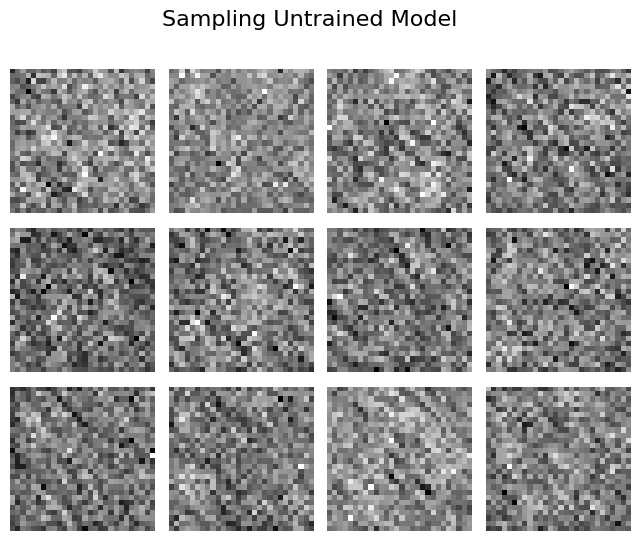

In [10]:
def sample(n_samples=12, sample_shape=(1, 28, 28), timesteps=1000, title="None"):
    x_hat = model.sample(n_samples=n_samples, sample_shape=sample_shape, timesteps=timesteps)
    n_rows = (n_samples + 3) // 4
    fig, axs = plt.subplots(
        nrows=n_rows, ncols=4, figsize=(8, 2 * n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, axis in enumerate(axs.flat[:n_samples]):
        axis.imshow(x_hat[i], cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

sample(title="Sampling Untrained Model")

Epoch 1 : 


Moving Average Loss: 1.6590:   7%|▋         | 1/15 [00:01<00:26,  1.88s/it]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 6.92 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
Moving Average Loss: 1.2901: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 2 : 


Moving Average Loss: 1.1449: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 3 : 


Moving Average Loss: 1.0345: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 4 : 


Moving Average Loss: 0.9412: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch 5 : 


Moving Average Loss: 0.8567: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Epoch 6 : 


Moving Average Loss: 0.7749: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 7 : 


Moving Average Loss: 0.6974: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 8 : 


Moving Average Loss: 0.6272: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 9 : 


Moving Average Loss: 0.5680: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 10 : 


100%|██████████| 1000/1000 [00:02<00:00, 349.26it/s]


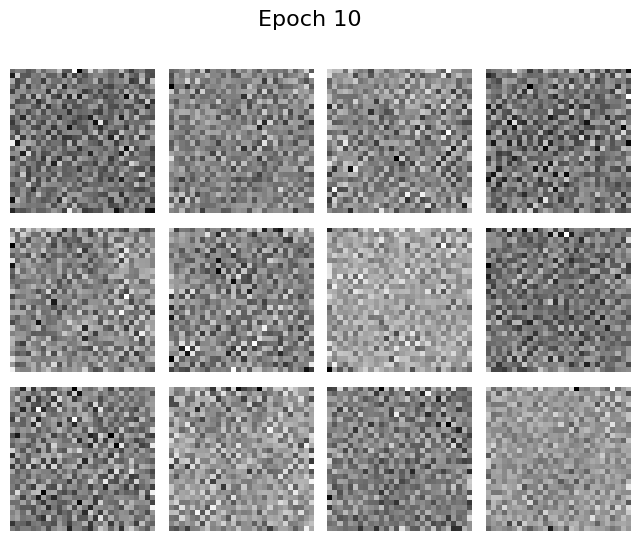

Epoch 11 : 


Moving Average Loss: 0.4713: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 12 : 


Moving Average Loss: 0.4370: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 13 : 


Moving Average Loss: 0.4031: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 14 : 


Moving Average Loss: 0.3809: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 15 : 


Moving Average Loss: 0.3563: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 16 : 


Moving Average Loss: 0.3369: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 17 : 


Moving Average Loss: 0.3188: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 18 : 


Moving Average Loss: 0.3021: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch 19 : 


Moving Average Loss: 0.2891: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 20 : 


100%|██████████| 1000/1000 [00:02<00:00, 348.76it/s]


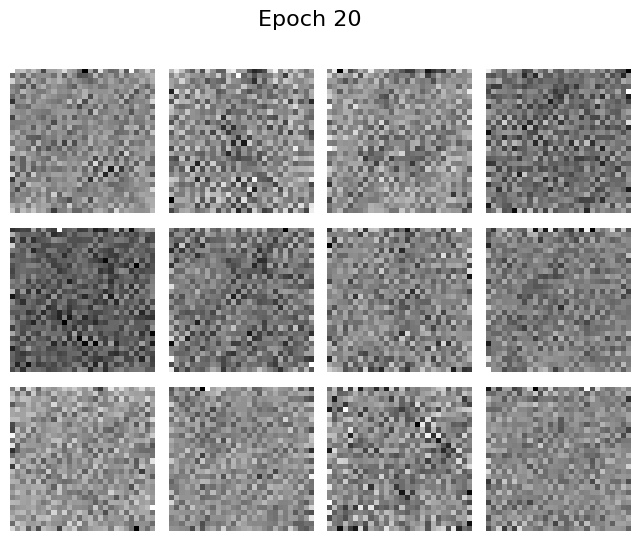

Epoch 21 : 


Moving Average Loss: 0.2625: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Epoch 22 : 


Moving Average Loss: 0.2528: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Epoch 23 : 


Moving Average Loss: 0.2428: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Epoch 24 : 


Moving Average Loss: 0.2350: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Epoch 25 : 


Moving Average Loss: 0.2278: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Epoch 26 : 


Moving Average Loss: 0.2209: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Epoch 27 : 


Moving Average Loss: 0.2158: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Epoch 28 : 


Moving Average Loss: 0.2060: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 29 : 


Moving Average Loss: 0.2010: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Epoch 30 : 


100%|██████████| 1000/1000 [00:02<00:00, 343.91it/s]


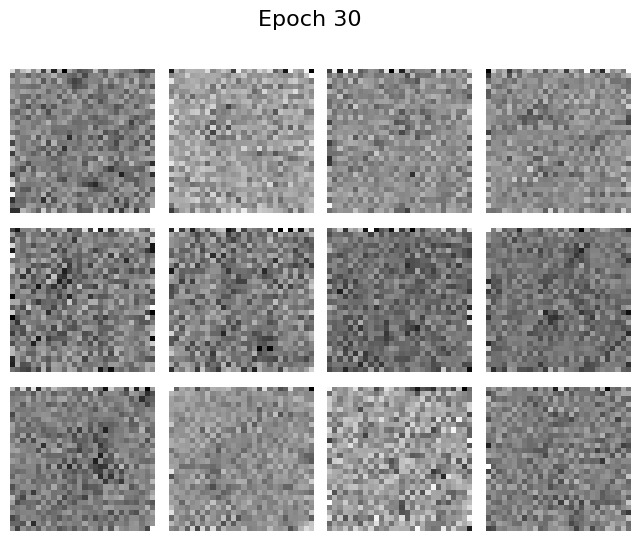

Epoch 31 : 


Moving Average Loss: 0.1922: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Epoch 32 : 


Moving Average Loss: 0.1866: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 33 : 


Moving Average Loss: 0.1814: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 34 : 


Moving Average Loss: 0.1776: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 35 : 


Moving Average Loss: 0.1732: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 36 : 


Moving Average Loss: 0.1684: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Epoch 37 : 


Moving Average Loss: 0.1663: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Epoch 38 : 


Moving Average Loss: 0.1628: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 39 : 


Moving Average Loss: 0.1610: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 40 : 


100%|██████████| 1000/1000 [00:02<00:00, 350.99it/s]


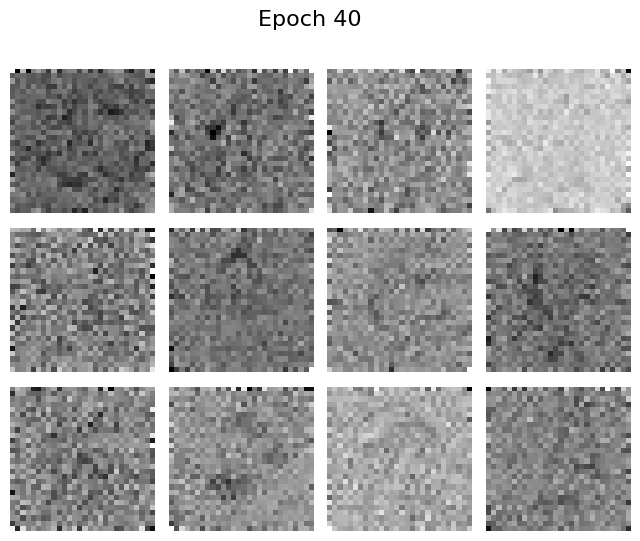

Epoch 41 : 


Moving Average Loss: 0.1538: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 42 : 


Moving Average Loss: 0.1526: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 43 : 


Moving Average Loss: 0.1489: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 44 : 


Moving Average Loss: 0.1463: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 45 : 


Moving Average Loss: 0.1438: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 46 : 


Moving Average Loss: 0.1426: 100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


Epoch 47 : 


Moving Average Loss: 0.1398: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 48 : 


Moving Average Loss: 0.1372: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 49 : 


Moving Average Loss: 0.1361: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 50 : 


100%|██████████| 1000/1000 [00:02<00:00, 343.11it/s]


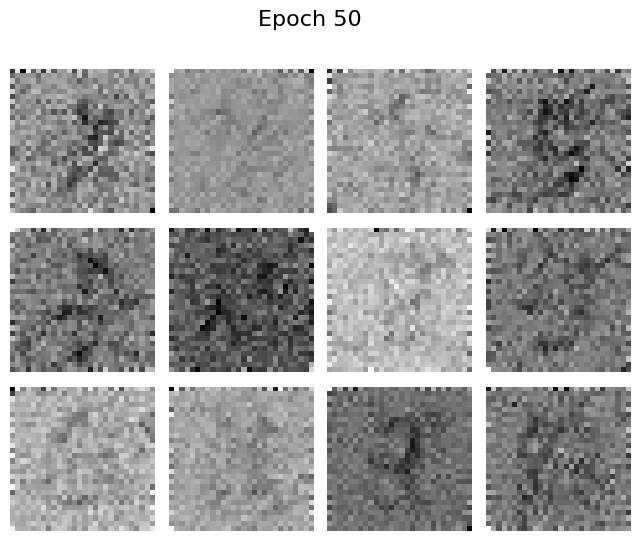

Epoch 51 : 


Moving Average Loss: 0.1319: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 52 : 


Moving Average Loss: 0.1320: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 53 : 


Moving Average Loss: 0.1295: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 54 : 


Moving Average Loss: 0.1287: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 55 : 


Moving Average Loss: 0.1252: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 56 : 


Moving Average Loss: 0.1248: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 57 : 


Moving Average Loss: 0.1239: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 58 : 


Moving Average Loss: 0.1215: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 59 : 


Moving Average Loss: 0.1205: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 60 : 


100%|██████████| 1000/1000 [00:02<00:00, 344.76it/s]


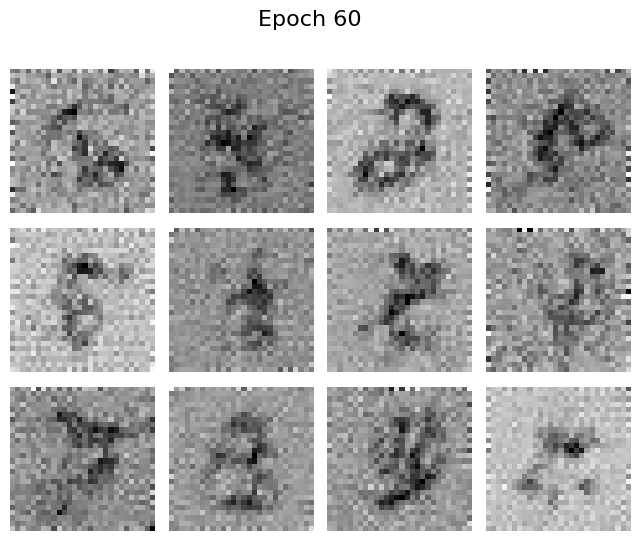

Epoch 61 : 


Moving Average Loss: 0.1195: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 62 : 


Moving Average Loss: 0.1172: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 63 : 


Moving Average Loss: 0.1156: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 64 : 


Moving Average Loss: 0.1151: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 65 : 


Moving Average Loss: 0.1135: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 66 : 


Moving Average Loss: 0.1139: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 67 : 


Moving Average Loss: 0.1124: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Epoch 68 : 


Moving Average Loss: 0.1098: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 69 : 


Moving Average Loss: 0.1103: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 70 : 


100%|██████████| 1000/1000 [00:02<00:00, 349.82it/s]


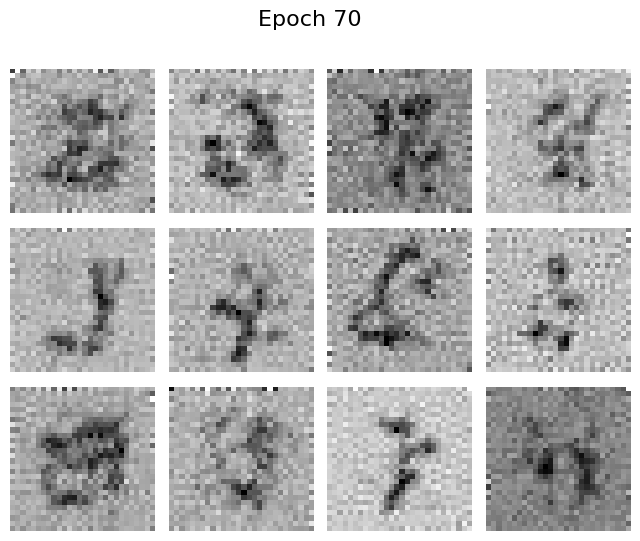

Epoch 71 : 


Moving Average Loss: 0.1083: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 72 : 


Moving Average Loss: 0.1074: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 73 : 


Moving Average Loss: 0.1083: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 74 : 


Moving Average Loss: 0.1061: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 75 : 


Moving Average Loss: 0.1060: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 76 : 


Moving Average Loss: 0.1056: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 77 : 


Moving Average Loss: 0.1050: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 78 : 


Moving Average Loss: 0.1040: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 79 : 


Moving Average Loss: 0.1040: 100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


Epoch 80 : 


100%|██████████| 1000/1000 [00:02<00:00, 344.11it/s]


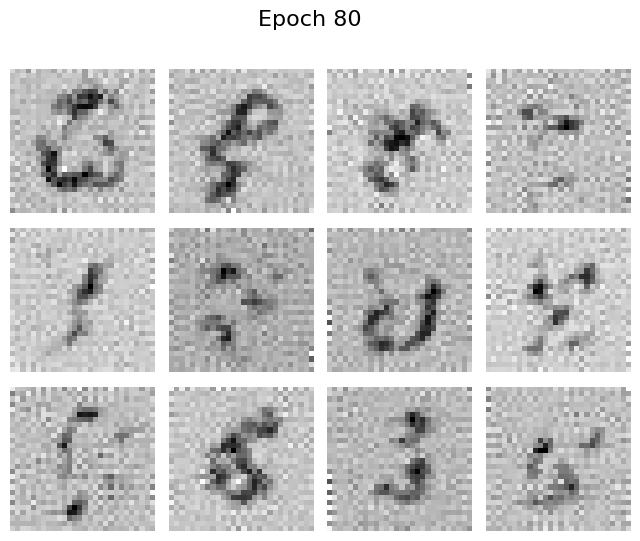

Epoch 81 : 


Moving Average Loss: 0.1022: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 82 : 


Moving Average Loss: 0.1016: 100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


Epoch 83 : 


Moving Average Loss: 0.1016: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 84 : 


Moving Average Loss: 0.1002: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 85 : 


Moving Average Loss: 0.0990: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 86 : 


Moving Average Loss: 0.0993: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 87 : 


Moving Average Loss: 0.0982: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 88 : 


Moving Average Loss: 0.0984: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 89 : 


Moving Average Loss: 0.0959: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 90 : 


100%|██████████| 1000/1000 [00:02<00:00, 345.39it/s]


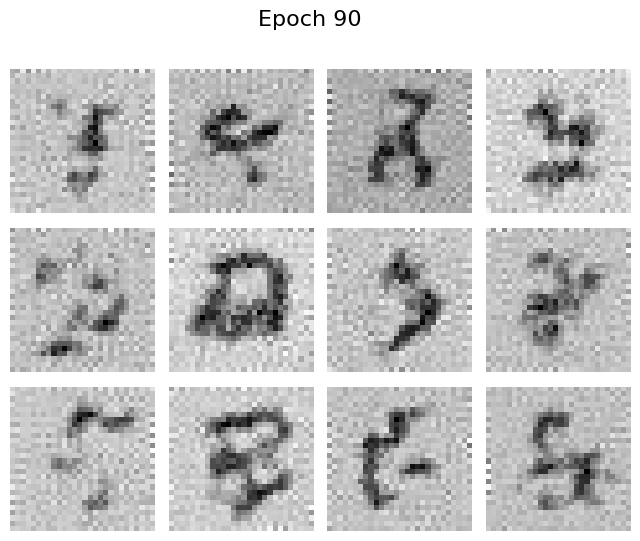

Epoch 91 : 


Moving Average Loss: 0.0956: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 92 : 


Moving Average Loss: 0.0965: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 93 : 


Moving Average Loss: 0.0966: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 94 : 


Moving Average Loss: 0.0953: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 95 : 


Moving Average Loss: 0.0943: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 96 : 


Moving Average Loss: 0.0939: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 97 : 


Moving Average Loss: 0.0932: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 98 : 


Moving Average Loss: 0.0936: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 99 : 


Moving Average Loss: 0.0926: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 100 : 


100%|██████████| 1000/1000 [00:02<00:00, 343.36it/s]


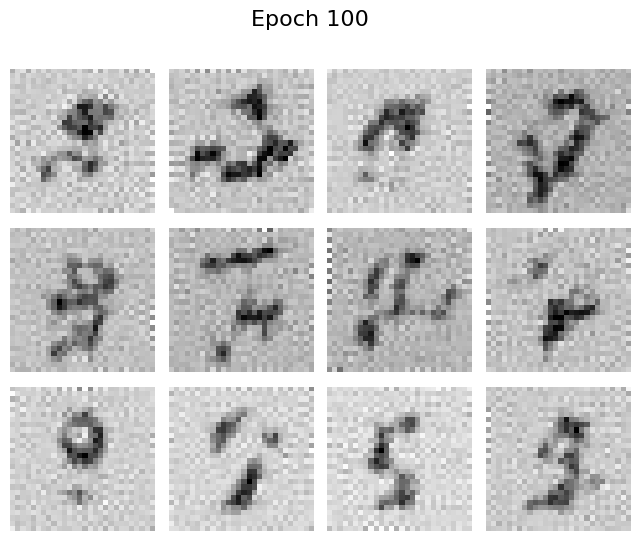

Epoch 101 : 


Moving Average Loss: 0.0920: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Epoch 102 : 


Moving Average Loss: 0.0912: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 103 : 


Moving Average Loss: 0.0908: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 104 : 


Moving Average Loss: 0.0903: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 105 : 


Moving Average Loss: 0.0915: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 106 : 


Moving Average Loss: 0.0897: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 107 : 


Moving Average Loss: 0.0897: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 108 : 


Moving Average Loss: 0.0899: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 109 : 


Moving Average Loss: 0.0888: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 110 : 


100%|██████████| 1000/1000 [00:02<00:00, 343.58it/s]


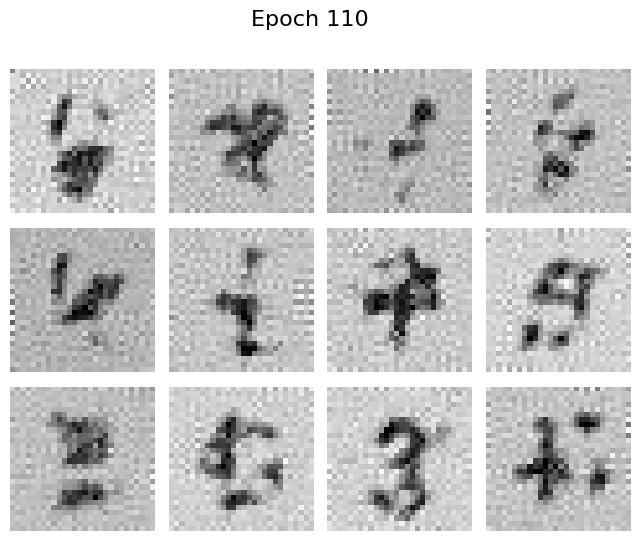

Epoch 111 : 


Moving Average Loss: 0.0877: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 112 : 


Moving Average Loss: 0.0882: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 113 : 


Moving Average Loss: 0.0868: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 114 : 


Moving Average Loss: 0.0882: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 115 : 


Moving Average Loss: 0.0854: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 116 : 


Moving Average Loss: 0.0872: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 117 : 


Moving Average Loss: 0.0862: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 118 : 


Moving Average Loss: 0.0865: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 119 : 


Moving Average Loss: 0.0854: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 120 : 


100%|██████████| 1000/1000 [00:02<00:00, 343.70it/s]


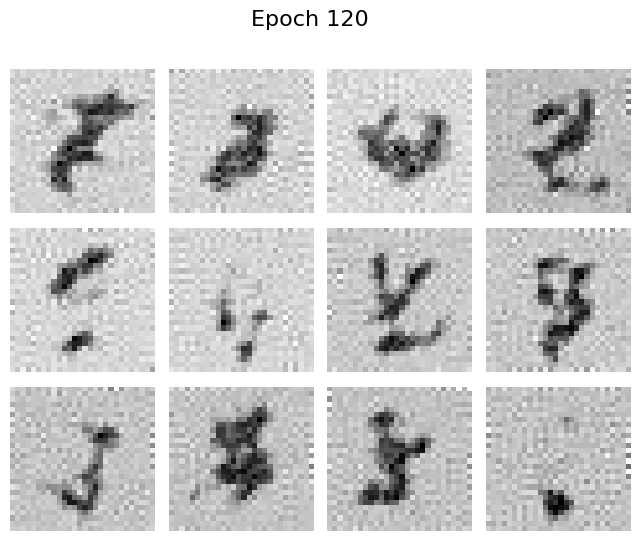

Epoch 121 : 


Moving Average Loss: 0.0853: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 122 : 


Moving Average Loss: 0.0848: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 123 : 


Moving Average Loss: 0.0845: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 124 : 


Moving Average Loss: 0.0830: 100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


Epoch 125 : 


Moving Average Loss: 0.0831: 100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


Epoch 126 : 


Moving Average Loss: 0.0828: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


Epoch 127 : 


Moving Average Loss: 0.0820: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 128 : 


Moving Average Loss: 0.0831: 100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


Epoch 129 : 


Moving Average Loss: 0.0822: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 130 : 


100%|██████████| 1000/1000 [00:02<00:00, 344.17it/s]


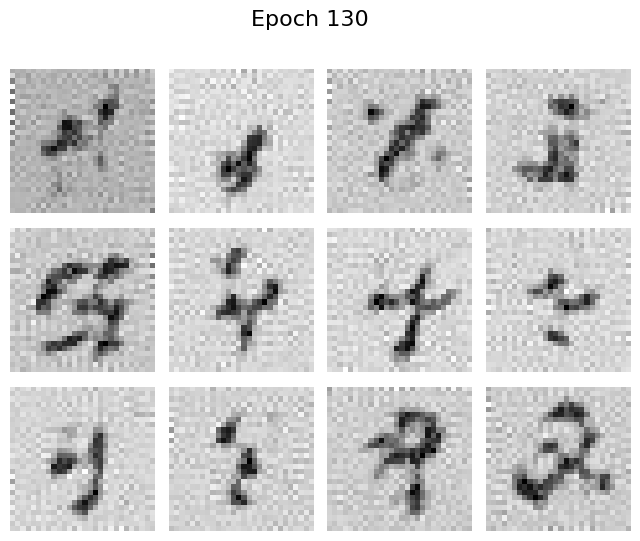

Epoch 131 : 


Moving Average Loss: 0.0821: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 132 : 


Moving Average Loss: 0.0807: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 133 : 


Moving Average Loss: 0.0811: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 134 : 


Moving Average Loss: 0.0806: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 135 : 


Moving Average Loss: 0.0813: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 136 : 


Moving Average Loss: 0.0802: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 137 : 


Moving Average Loss: 0.0797: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 138 : 


Moving Average Loss: 0.0794: 100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


Epoch 139 : 


Moving Average Loss: 0.0793: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 140 : 


100%|██████████| 1000/1000 [00:02<00:00, 345.33it/s]


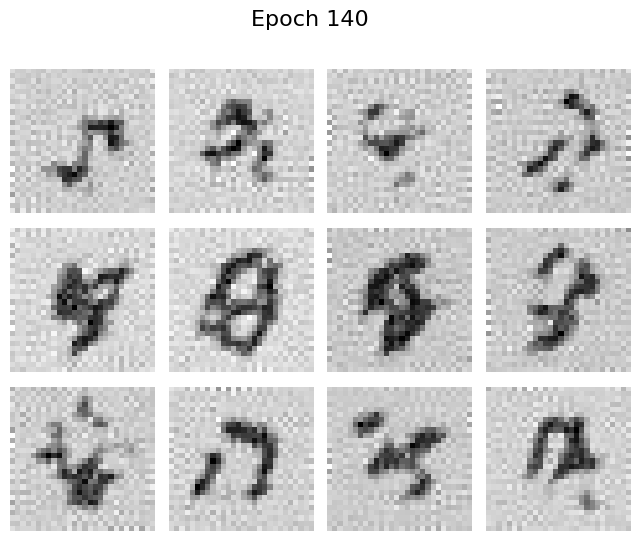

Epoch 141 : 


Moving Average Loss: 0.0784: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 142 : 


Moving Average Loss: 0.0791: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Epoch 143 : 


Moving Average Loss: 0.0775: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 144 : 


Moving Average Loss: 0.0775: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 145 : 


Moving Average Loss: 0.0781: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 146 : 


Moving Average Loss: 0.0773: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 147 : 


Moving Average Loss: 0.0766: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Epoch 148 : 


Moving Average Loss: 0.0772: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 149 : 


Moving Average Loss: 0.0764: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 150 : 


100%|██████████| 1000/1000 [00:02<00:00, 347.86it/s]


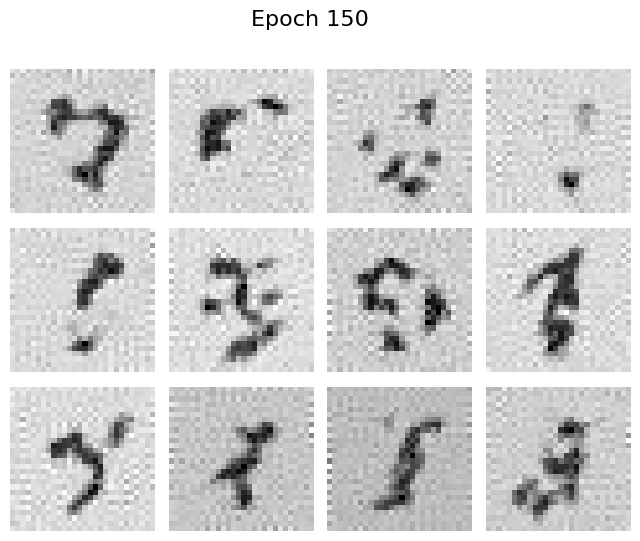

Epoch 151 : 


Moving Average Loss: 0.0756: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 152 : 


Moving Average Loss: 0.0763: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 153 : 


Moving Average Loss: 0.0760: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 154 : 


Moving Average Loss: 0.0739: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 155 : 


Moving Average Loss: 0.0738: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch 156 : 


Moving Average Loss: 0.0749: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 157 : 


Moving Average Loss: 0.0743: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 158 : 


Moving Average Loss: 0.0744: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 159 : 


Moving Average Loss: 0.0741: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 160 : 


100%|██████████| 1000/1000 [00:02<00:00, 344.64it/s]


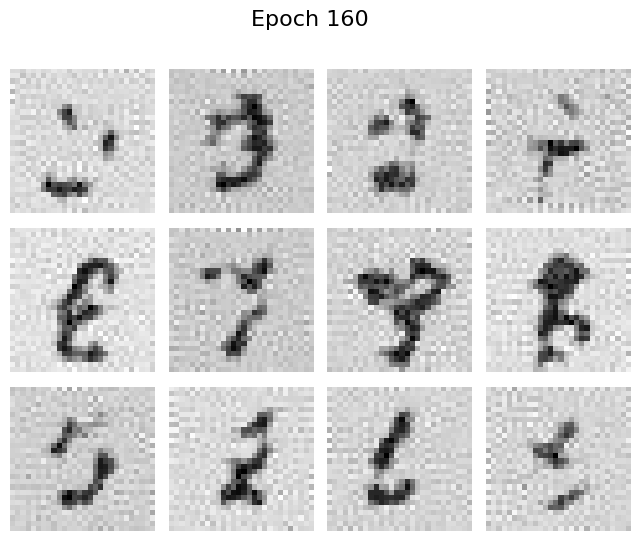

Epoch 161 : 


Moving Average Loss: 0.0731: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 162 : 


Moving Average Loss: 0.0719: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 163 : 


Moving Average Loss: 0.0728: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 164 : 


Moving Average Loss: 0.0735: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 165 : 


Moving Average Loss: 0.0722: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 166 : 


Moving Average Loss: 0.0728: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 167 : 


Moving Average Loss: 0.0724: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 168 : 


Moving Average Loss: 0.0712: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 169 : 


Moving Average Loss: 0.0721: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 170 : 


100%|██████████| 1000/1000 [00:02<00:00, 342.34it/s]


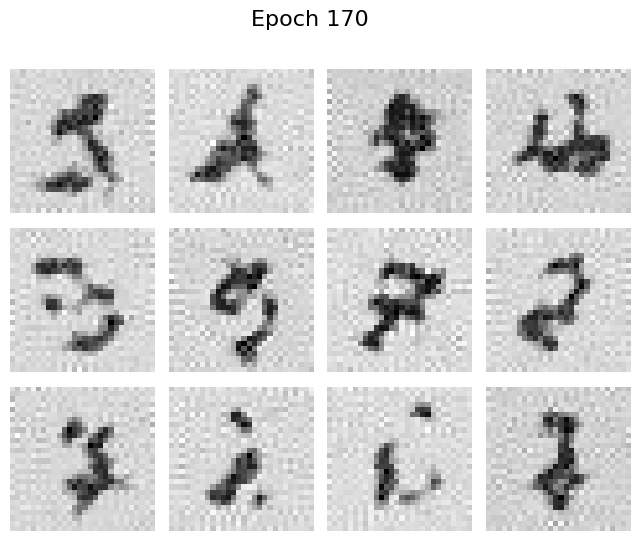

Epoch 171 : 


Moving Average Loss: 0.0718: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 172 : 


Moving Average Loss: 0.0714: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 173 : 


Moving Average Loss: 0.0717: 100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


Epoch 174 : 


Moving Average Loss: 0.0717: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 175 : 


Moving Average Loss: 0.0695: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 176 : 


Moving Average Loss: 0.0692: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 177 : 


Moving Average Loss: 0.0712: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 178 : 


Moving Average Loss: 0.0703: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 179 : 


Moving Average Loss: 0.0699: 100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


Epoch 180 : 


100%|██████████| 1000/1000 [00:02<00:00, 346.09it/s]


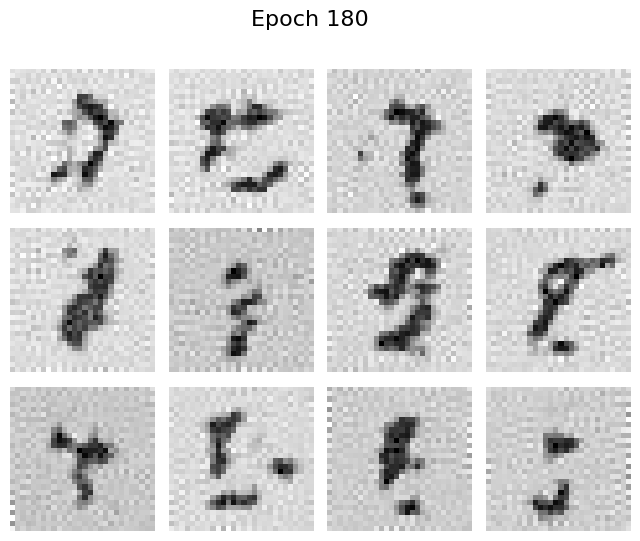

Epoch 181 : 


Moving Average Loss: 0.0693: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 182 : 


Moving Average Loss: 0.0688: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 183 : 


Moving Average Loss: 0.0689: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 184 : 


Moving Average Loss: 0.0680: 100%|██████████| 15/15 [00:06<00:00,  2.14it/s]


Epoch 185 : 


Moving Average Loss: 0.0695: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 186 : 


Moving Average Loss: 0.0685: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 187 : 


Moving Average Loss: 0.0680: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 188 : 


Moving Average Loss: 0.0677: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 189 : 


Moving Average Loss: 0.0671: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 190 : 


100%|██████████| 1000/1000 [00:02<00:00, 344.29it/s]


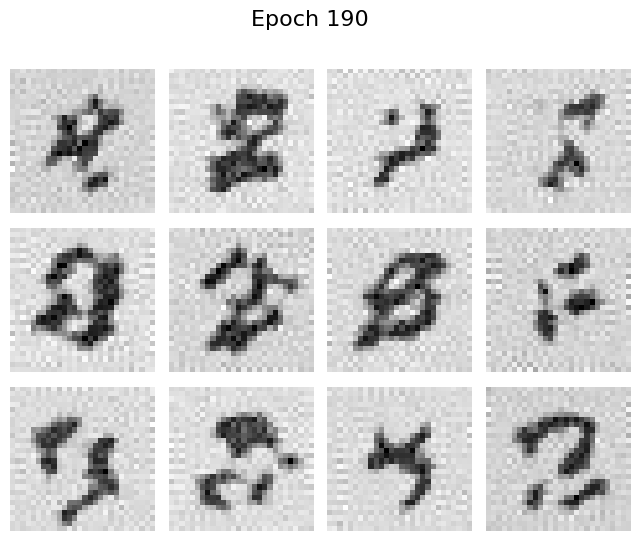

Epoch 191 : 


Moving Average Loss: 0.0666: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 192 : 


Moving Average Loss: 0.0671: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 193 : 


Moving Average Loss: 0.0671: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 194 : 


Moving Average Loss: 0.0673: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 195 : 


Moving Average Loss: 0.0663: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 196 : 


Moving Average Loss: 0.0669: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 197 : 


Moving Average Loss: 0.0654: 100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


Epoch 198 : 


Moving Average Loss: 0.0650: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 199 : 


Moving Average Loss: 0.0658: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 200 : 


100%|██████████| 1000/1000 [00:02<00:00, 340.95it/s]


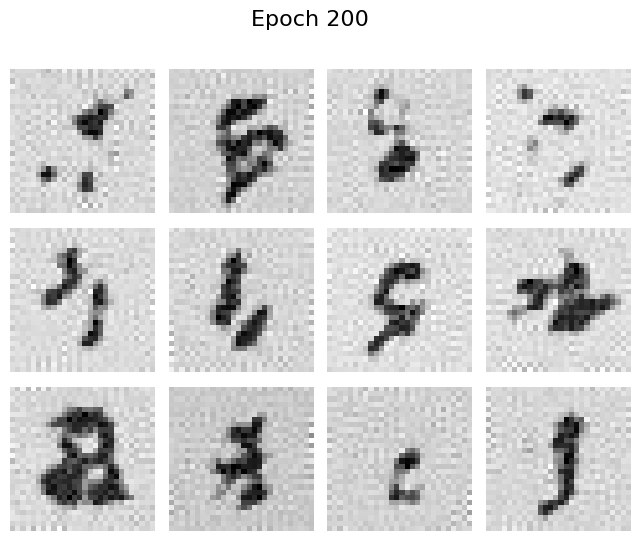

Epoch 201 : 


Moving Average Loss: 0.0672: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 202 : 


Moving Average Loss: 0.0647: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 203 : 


Moving Average Loss: 0.0643: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 204 : 


Moving Average Loss: 0.0645: 100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


Epoch 205 : 


Moving Average Loss: 0.0643: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 206 : 


Moving Average Loss: 0.0650: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 207 : 


Moving Average Loss: 0.0648: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 208 : 


Moving Average Loss: 0.0643: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 209 : 


Moving Average Loss: 0.0643: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 210 : 


100%|██████████| 1000/1000 [00:02<00:00, 340.90it/s]


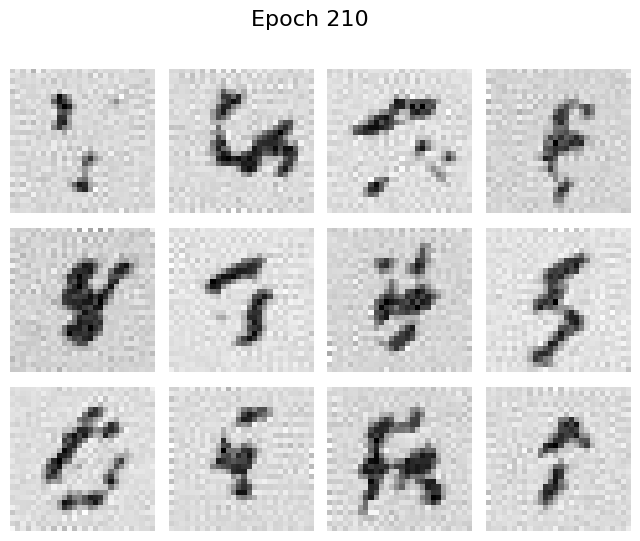

Epoch 211 : 


Moving Average Loss: 0.0634: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 212 : 


Moving Average Loss: 0.0642: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 213 : 


Moving Average Loss: 0.0638: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 214 : 


Moving Average Loss: 0.0636: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 215 : 


Moving Average Loss: 0.0633: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch 216 : 


Moving Average Loss: 0.0627: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 217 : 


Moving Average Loss: 0.0626: 100%|██████████| 15/15 [00:06<00:00,  2.14it/s]


Epoch 218 : 


Moving Average Loss: 0.0634: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch 219 : 


Moving Average Loss: 0.0625: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Epoch 220 : 


100%|██████████| 1000/1000 [00:02<00:00, 345.64it/s]


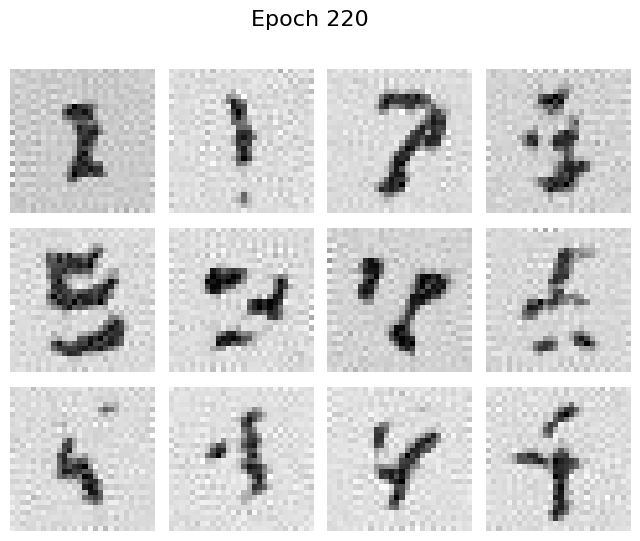

Epoch 221 : 


Moving Average Loss: 0.0624: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Epoch 222 : 


Moving Average Loss: 0.0619: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 223 : 


Moving Average Loss: 0.0624: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 224 : 


Moving Average Loss: 0.0625: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 225 : 


Moving Average Loss: 0.0615: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 226 : 


Moving Average Loss: 0.0609: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 227 : 


Moving Average Loss: 0.0614: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 228 : 


Moving Average Loss: 0.0612: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 229 : 


Moving Average Loss: 0.0612: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 230 : 


100%|██████████| 1000/1000 [00:02<00:00, 344.88it/s]


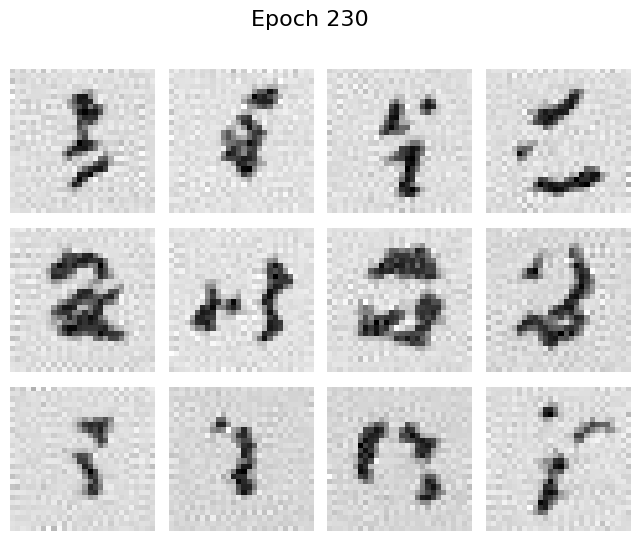

Epoch 231 : 


Moving Average Loss: 0.0608: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 232 : 


Moving Average Loss: 0.0610: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 233 : 


Moving Average Loss: 0.0607: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 234 : 


Moving Average Loss: 0.0609: 100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


Epoch 235 : 


Moving Average Loss: 0.0612: 100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


Epoch 236 : 


Moving Average Loss: 0.0604: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 237 : 


Moving Average Loss: 0.0599: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 238 : 


Moving Average Loss: 0.0601: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 239 : 


Moving Average Loss: 0.0599: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 240 : 


100%|██████████| 1000/1000 [00:02<00:00, 337.11it/s]


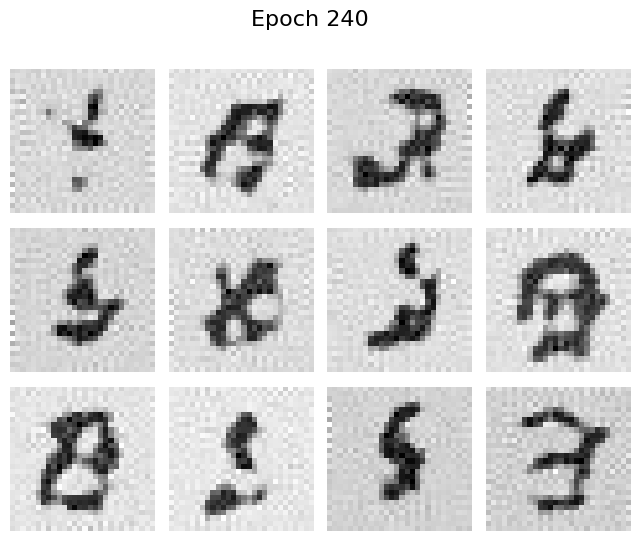

Epoch 241 : 


Moving Average Loss: 0.0597: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 242 : 


Moving Average Loss: 0.0594: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 243 : 


Moving Average Loss: 0.0594: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 244 : 


Moving Average Loss: 0.0596: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 245 : 


Moving Average Loss: 0.0591: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 246 : 


Moving Average Loss: 0.0589: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 247 : 


Moving Average Loss: 0.0589: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 248 : 


Moving Average Loss: 0.0597: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 249 : 


Moving Average Loss: 0.0587: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 250 : 


100%|██████████| 1000/1000 [00:02<00:00, 343.46it/s]


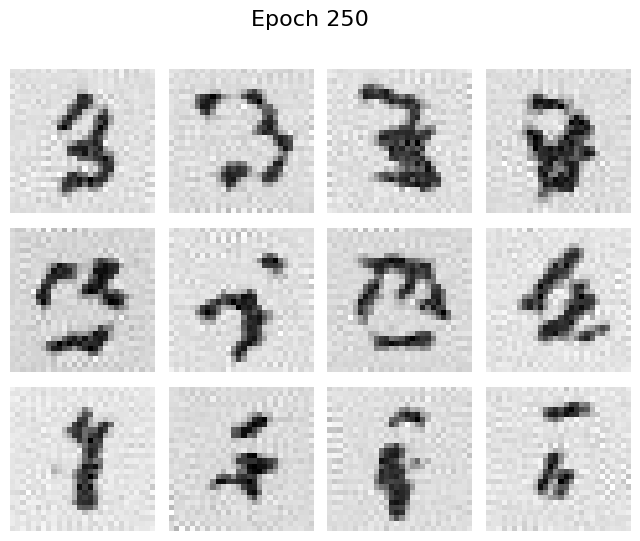

Epoch 251 : 


Moving Average Loss: 0.0582: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 252 : 


Moving Average Loss: 0.0584: 100%|██████████| 15/15 [00:06<00:00,  2.14it/s]


Epoch 253 : 


Moving Average Loss: 0.0587: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 254 : 


Moving Average Loss: 0.0579: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Epoch 255 : 


Moving Average Loss: 0.0577: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 256 : 


Moving Average Loss: 0.0580: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 257 : 


Moving Average Loss: 0.0577: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 258 : 


Moving Average Loss: 0.0577: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 259 : 


Moving Average Loss: 0.0569: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Epoch 260 : 


100%|██████████| 1000/1000 [00:02<00:00, 341.31it/s]


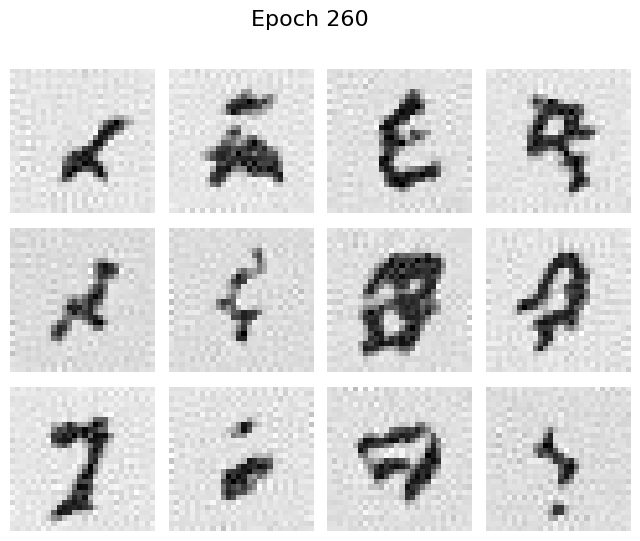

Epoch 261 : 


Moving Average Loss: 0.0565: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 262 : 


Moving Average Loss: 0.0584: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 263 : 


Moving Average Loss: 0.0564: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 264 : 


Moving Average Loss: 0.0566: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 265 : 


Moving Average Loss: 0.0577: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Epoch 266 : 


Moving Average Loss: 0.0567: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 267 : 


Moving Average Loss: 0.0560: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch 268 : 


Moving Average Loss: 0.0563: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 269 : 


Moving Average Loss: 0.0560: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 270 : 


100%|██████████| 1000/1000 [00:02<00:00, 342.89it/s]


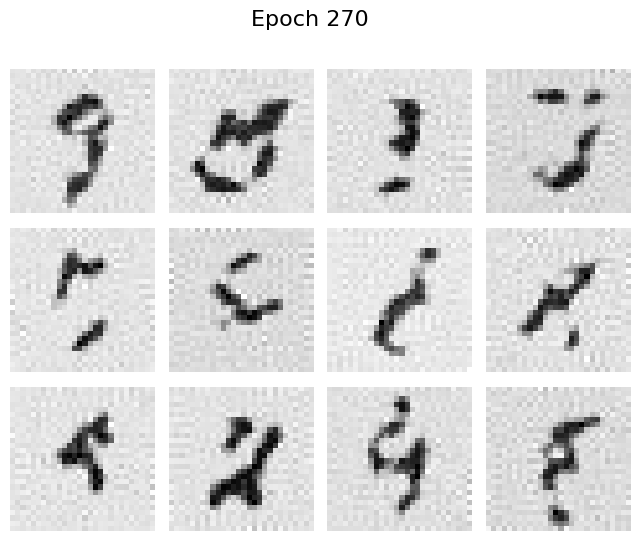

Epoch 271 : 


Moving Average Loss: 0.0560: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 272 : 


Moving Average Loss: 0.0554: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 273 : 


Moving Average Loss: 0.0557: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 274 : 


Moving Average Loss: 0.0554: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 275 : 


Moving Average Loss: 0.0565: 100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


Epoch 276 : 


Moving Average Loss: 0.0557: 100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


Epoch 277 : 


Moving Average Loss: 0.0547: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch 278 : 


Moving Average Loss: 0.0556: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 279 : 


Moving Average Loss: 0.0553: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 280 : 


100%|██████████| 1000/1000 [00:02<00:00, 339.53it/s]


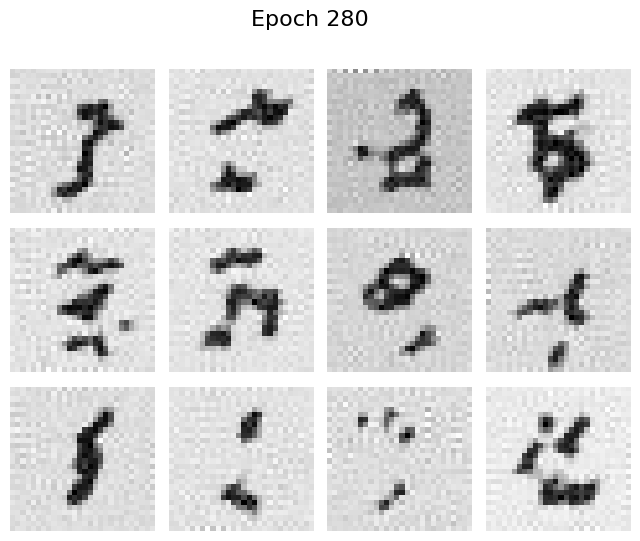

Epoch 281 : 


Moving Average Loss: 0.0551: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


Epoch 282 : 


Moving Average Loss: 0.0550: 100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


Epoch 283 : 


Moving Average Loss: 0.0547: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 284 : 


Moving Average Loss: 0.0547: 100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


Epoch 285 : 


Moving Average Loss: 0.0550: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 286 : 


Moving Average Loss: 0.0551: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 287 : 


Moving Average Loss: 0.0546: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 288 : 


Moving Average Loss: 0.0546: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 289 : 


Moving Average Loss: 0.0542: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 290 : 


100%|██████████| 1000/1000 [00:02<00:00, 343.25it/s]


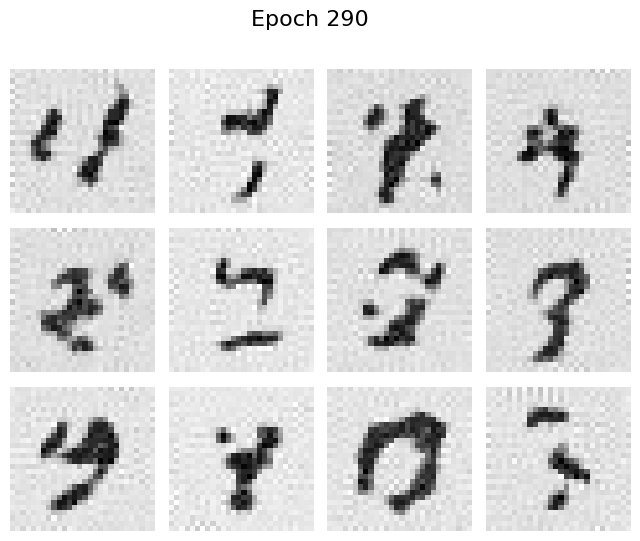

Epoch 291 : 


Moving Average Loss: 0.0534: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 292 : 


Moving Average Loss: 0.0543: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 293 : 


Moving Average Loss: 0.0550: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 294 : 


Moving Average Loss: 0.0543: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 295 : 


Moving Average Loss: 0.0540: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 296 : 


Moving Average Loss: 0.0545: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 297 : 


Moving Average Loss: 0.0543: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 298 : 


Moving Average Loss: 0.0535: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Epoch 299 : 


Moving Average Loss: 0.0525: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 300 : 


100%|██████████| 1000/1000 [00:02<00:00, 345.23it/s]


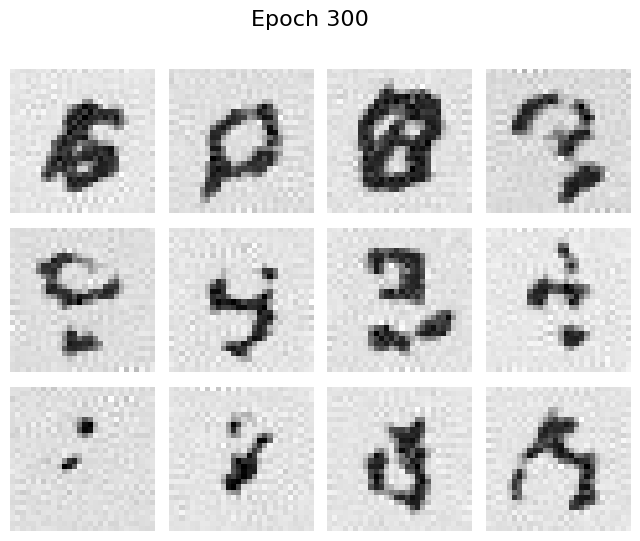

In [11]:
def train_loop():
    losses = []
    print_every = 10
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} : ")
        model.train()
        pbar = tqdm(dataloader)
        for x, _ in pbar:
            # put batch in device:
            x = x.to(device).view(-1, 1, 28, 28)
            # get t for this iteration:
            timesteps = torch.randint(1, n_T + 1, (x.shape[0],)).to(device)
            # epsilon in N(0,1)
            eps = torch.randn_like(x)
            # zero gradients
            optim.zero_grad()
            # noise the image:
            x_t = schedules["sqrt_abar"][timesteps, None, None, None] * x + \
                  schedules["sqrt_inv_abar"][timesteps, None, None, None] * eps
            # normalize t:
            t = timesteps/n_T
            # get model's prediction of epsilon:
            eps_hat = model(x_t, t)
            # compute loss:
            loss = loss_fn(eps_hat, eps)
            # backpropagate
            loss.backward()
            # log loss:
            losses.append(loss.item())
            # average loss for last 10 iterations:
            avg_loss = np.asarray(losses)[-10:].mean()
            # print
            pbar.set_description(f"Moving Average Loss: {avg_loss:.4f}")
            # update weights:
            optim.step()
        # generate samples:
        if (epoch + 1) % print_every == 0:
            with torch.no_grad():
                model.eval()
                sample(title=f"Epoch {epoch+1}")
                model.train()
    return losses

train_losses = train_loop()